In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as optim
from scipy import stats
import cvxpy as cp
from tqdm import tqdm
import json
import os
import sys
import seaborn as sns
import pandas as pd
sys.path.append('..')

from src.samplers.importance_sampler import *
from src.samplers.utils import check_feasibility_out_of_sample
from src.samplers import preprocessing as pre
from src.data_utils import synthetic as synth
from src.solvers import scenario_approx as SA
from src.solvers import utils as SU
from src.solvers import analytical_approx as AA

# Assuming initial Gaussians to be distributed non-standardly
## Standartize first

In [2]:
mu = np.ones(2)
Sigma = np.array([[1, 2], [3, 4]]) * 0.1
# making matrix psd
Sigma = Sigma.dot(Sigma.T)
J = 90
tau = 5
Gamma, Beta = synth.regular_polyhedron(J, tau)
#A = Gamma
Gamma, Beta, A = pre.standartize(Gamma, Beta, mu, Sigma)
c = np.array([-1, 1])

In [3]:
eta = 0.05

# Union bound (Boole's approximation)
Assume the system is standartized $\left(\chi \sim \mathcal{N}(0, I_n), ~ \| a_i \|_2 = 1\right)$
$$
\begin{aligned}
\mathbb{P} \Bigg\{ \forall ~ i ~ \gamma_i^\top x + &a_i^\top \chi \leq \beta_i \Bigg\} \geq 1 - \eta \\
&\Updownarrow \\
\mathbb{P} \Bigg\{ \bigcup_{i=1}^J ~ \gamma_i^\top x + &a_i^\top \chi > \beta_i \Bigg\} \leq  \eta
\end{aligned}
$$
Note that
$$
\mathbb{P} \Bigg\{ \bigcup_{i=1}^J ~ \gamma_i^\top x + a_i^\top \chi > \beta_i \Bigg\} \leq \sum_{i=1}^J \mathbb{P} \Bigg\{  \gamma_i^\top x + a_i^\top \chi > \beta_i \Bigg\}
$$
Due to the semi-additivity of measure $\mathbb{P}$. Thus, ensuring R.H.S. to be less thatn $\eta$, we ensure original probability to be less than $\eta$ -- conservative approximation.

In [4]:
# Standartization in prior must be conducted
res_boole = AA.inner_polyhedral(eta, Gamma, Beta, c = c)
boole_prob = check_feasibility_out_of_sample(res_boole.x, Gamma, Beta, A, 1000000)
print(boole_prob)

/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimiziation Succeeded: True
0.987639


In [5]:
Gamma.dot(res_boole.x) - Beta
AA.inner_polyhedral_constraint(res_boole.x, Gamma, Beta, eta)

-1.3371814174586993e-05

# Solve several scenario approximations

## Estimation of probability of feasibility of approximation solution to be feasible for original problem
> 1. For each $N$ solve approximation $L$ times with different samples
> 2. Based on $L$ observations for solution of approximation with $N$ samples, estimate prob. of feasibility for original problem
> 3. Based on $L$ observations make box plots for ''conservativity'' - $\hat{\mathbb{P}}(x \texttt{ is feasible}) - \eta$

# **<font color='red'>Attention!</font>**
Setting $ L > 1 $ may lead to a long computational process!

In [6]:
# Store sigma and mu, next, the solutions for approximation will be pushed
results = {"Sigma": [[float(v) for v in row] for row in Sigma], 
           "mu": [float(v) for v in mu]}
N0 = 1
ks = list(range(1, 55))[::5]
L = 40

In [7]:
for k in tqdm(ks):
    N = N0 * k
    for l in range(L):
        res = SU.solve_approximations(Gamma, Beta, A, N, c, eta)
        
        try:
            results[N].append(res)
        except KeyError:
            results[N] = []
            results[N].append(res)

  0%|          | 0/11 [00:00<?, ?it/s]

# Unpack results (for one simulation) and plot them

In [8]:
save_dir = os.path.join("..", "saves", "synthetic")
json_file = os.path.join("J_" + str(J) + "_tau_" + str(tau) + "_N_" + str(N0 * ks[-1]) + ".json")

In [12]:
# try:
#     with open(os.path.join(save_dir, json_file), 'w') as fp:
#         json.dump(results, fp, indent=4)
# except FileNotFoundError:
#     os.makedirs(save_dir)
#     with open(os.path.join(save_dir, json_file), 'w') as fp:
#         json.dump(results, fp, indent=4)

In [13]:
# # load if necessary
# with open(json_file, 'r') as fp:
#     results = json.load(fp)

Text(0, 0.5, 'Objective')

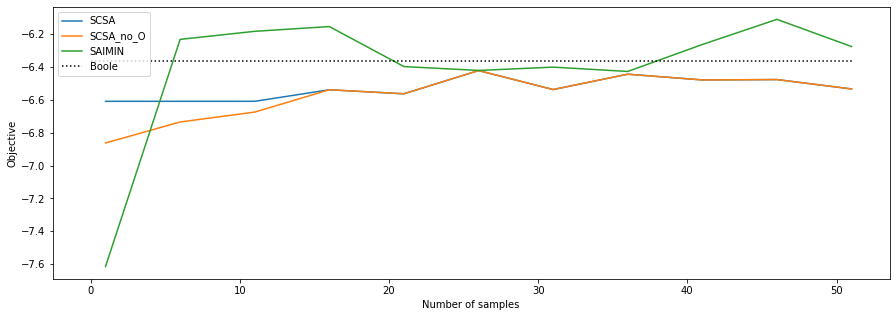

In [9]:
plt.figure(figsize=(15, 5))
def unpack_results(results, k=0):
    try:
        names = list(results[N0][k].keys())
    except KeyError:
        names = list(results[str(N0)][k].keys())
    fns = []
    xs = []
    for r in results.keys():
        if r not in ["Sigma", "mu"]:
            for v in results[r][k].values():
                try:
                    xs.append(v[0])
                    fns.append(np.dot(v[0], c))
                except ValueError:
                    fns.append(np.nan)
    fns = np.array(fns).reshape(-1, len(names))
    xs = np.array(xs).reshape(-1, len(names), A.shape[1])
    return fns, xs, names
fns, xs, names = unpack_results(results=results, k=1)
for i in range(fns.shape[1]):
    plt.plot(np.array(ks) * N0, fns[:, i], label=names[i])

plt.hlines(y = [res_boole.fun], xmin = 0, xmax = ks[-1] * N0, label='Boole', color='black', linestyle='dotted')
plt.legend()
plt.xlabel("Number of samples")
plt.ylabel("Objective")

# Out of sample validation

In [10]:
boole_prob = check_feasibility_out_of_sample(res_boole.x, Gamma, Beta, A, 100000)
scenarios_probs = np.array([np.apply_along_axis(arr=xs[:, i, :], func1d=lambda x: check_feasibility_out_of_sample(x, Gamma, Beta, A, 100000), axis=1) for i in range(len(names))])

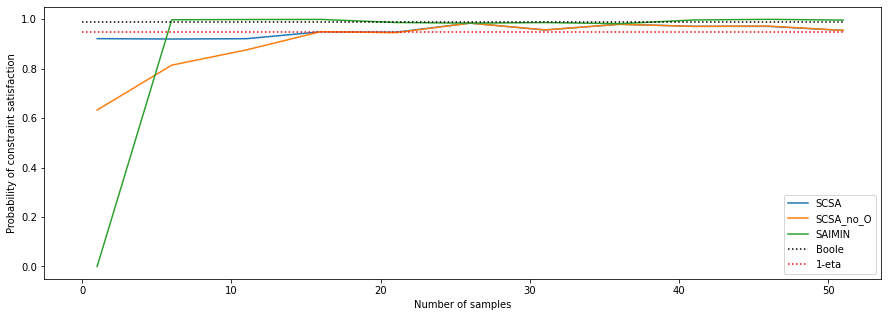

In [11]:
plt.figure(figsize=(15, 5))

for i in range(scenarios_probs.shape[0]):
    plt.plot(np.array(ks) * N0, scenarios_probs[i,:], label=names[i])

plt.hlines(y = [boole_prob], xmin = 0, xmax = ks[-1] * N0, label='Boole', color='black', linestyle='dotted')
plt.hlines(y = [1-eta], xmin = 0, xmax = ks[-1] * N0, label='1-eta', color='red', linestyle='dotted')
plt.legend()
#plt.yscale('log')
#plt.ylim((1-eta-1e-2, 1 + 1e-4))
plt.xlabel("Number of samples")
plt.ylabel("Probability of constraint satisfaction")
plt.show()

# Plot results of multiple simulations
> 1. Estimates for probability of a solution of approximation to be feasible for original problem ($\beta$)
> 2. Box plots for estimates of probability of satisfying constraints

In [12]:
scenario_prob_estimate = np.zeros((len(names), len(ks)))
scenario_probs_several_starts = []
for k in tqdm(range(L)):
    _, xs, names = unpack_results(results=results, k=k)
    boole_prob = check_feasibility_out_of_sample(res_boole.x, Gamma, Beta, A, 100000)
    scenarios_probs = np.array([np.apply_along_axis(arr=xs[:, i, :], func1d=lambda x: check_feasibility_out_of_sample(x, Gamma, Beta, A, 100000), axis=1) for i in range(3)])
    scenario_prob_estimate += (scenarios_probs - eta >= 0.)
    scenario_probs_several_starts.append(scenarios_probs)
scenario_prob_esimate = scenario_prob_estimate / L
scenario_probs_several_starts = np.array(np.stack(scenario_probs_several_starts))

  0%|          | 0/40 [00:00<?, ?it/s]

In [17]:
pd_boxplot = pd.DataFrame({"N": [], "Method": [], "Prob_est - 1-eta": []})
for method_idx in range(scenario_probs_several_starts.shape[1]):
    data = scenario_probs_several_starts[:, method_idx, :]
    pd_boxplot_tmp = pd.DataFrame({"N": [], "Method": [], "Prob_est - 1-eta": []})
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            pd_boxplot_tmp = pd.concat([pd_boxplot_tmp, pd.DataFrame({"N": [ks[j] * N0], "Method": [names[method_idx]], "Prob_est - 1-eta": [data[i, j] - (1-eta)]})], ignore_index=True)
    pd_boxplot = pd.concat([pd_boxplot, pd_boxplot_tmp])

/var/folders/x3/2q_gzsqs643dbh4q2k13s0z80000gn/T/ipykernel_2023/3333476108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = (pdSeries_tmp["Prob_est - 1-eta"] > 0).values
/var/folders/x3/2q_gzsqs643dbh4q2k13s0z80000gn/T/ipykernel_2023/3333476108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = (pdSeries_tmp["Prob_est - 1-eta"] > 0).values
/var/folders/x3/2q_gzsqs643dbh4q2k13s0z80000gn/T/ipykernel_2023/3333476108.py:7: S

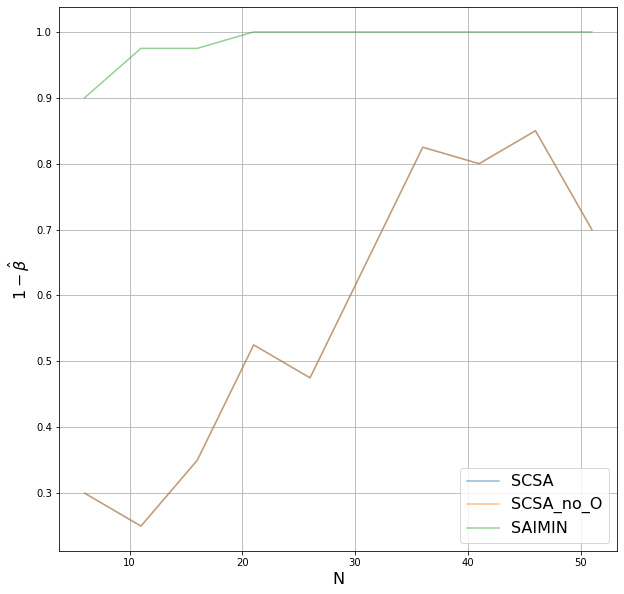

In [136]:
plt.figure(figsize=(10, 10))
fsize = 16
figure_path_1_beta = os.path.join(save_dir, "figures", "1_beta_J_" + str(J) + "_tau_" + str(tau) + "_N_" + str(N0 * ks[-1]) + ".png")
for i in range(len(names)):
    pdSeries_tmp = (pd_boxplot.loc[(pd_boxplot["Method"] == names[i]) & (pd_boxplot["N"] > 2)])
    #pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = pdSeries_tmp["Prob_est - 1-eta"].apply(lambda x: 1.0 if x >= 0 else 0.0)
    pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = (pdSeries_tmp["Prob_est - 1-eta"] > 0).values
    pdSeries_tmp = pdSeries_tmp.groupby("N").mean()
    x_plot = pdSeries_tmp.index
    y_plot = pdSeries_tmp["Prob_est - 1-eta"].values
    plt.plot(x_plot, y_plot, label=names[i], alpha=0.5)
    #plt.plot(np.array(ks)[1:] * N0, scenario_prob_esimate[i, 1:], label=names[i])
plt.xlabel("N", fontsize=fsize)
plt.ylabel(r"$1 - \hat{\beta}$", fontsize=fsize)
plt.grid()
plt.legend(prop={'size': fsize})
#plt.savefig(figure_path_1_beta)

(-0.1, 0.1)

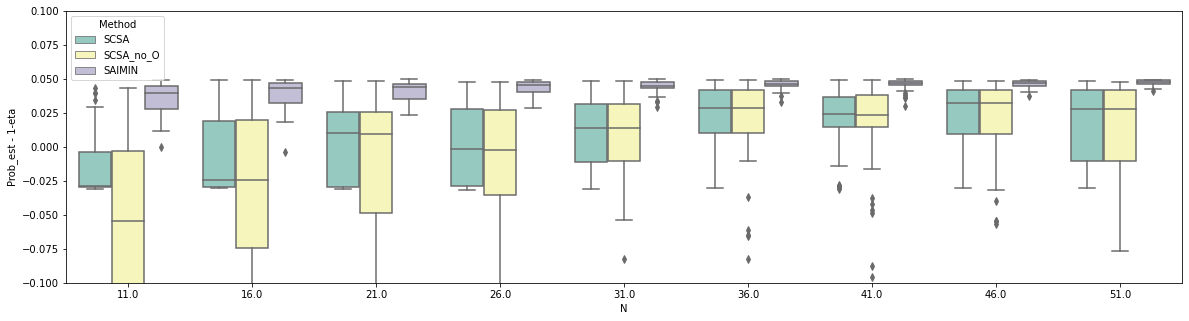

In [76]:
figure_path_box = os.path.join(save_dir, "figures", "boxplot_J_" + str(J) + "_tau_" + str(tau) + "_N_" + str(N0 * ks[-1]) + ".png")
plt.figure(figsize=(20, 5))
ax = sns.boxplot(x="N", y="Prob_est - 1-eta", hue="Method",
                 data=pd_boxplot[pd_boxplot["N"] > 6], palette="Set3")
plt.ylim((-0.1, 0.1))
#plt.grid()
#plt.savefig(figure_path_box)